# BERT Fine-Tuning Sentence Classification


1. Installing the Hugging Face PyTorch Interface for BERT

In [2]:
#@title Installing the Hugging Face PyTorch Interface for Bert
# !pip install pytorch-pretrained-bert pytorch-nlp
!pip install transformers scikit-learn


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


2. Importing the Modules

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import pandas as pd
import numpy as np


3. Specifying CUDA as the Device for Torch

In [4]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(f"Using device: {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "Using CPU")


Using device: NVIDIA RTX 6000 Ada Generation


4. Loading the Dataset

In [5]:
# Source of dataset: https://nyu-mll.github.io/CoLA/
# df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = pd.read_csv("IMDB Dataset.csv", nrows=2000)

df.shape

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


5. Data Cleaning (Removing HTML Tags and URLs)

In [6]:
import re
def clean_text(text):
    text = re.sub(r'<[^<]+?>', '', text)  # Remove HTML tags
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)  # Remove URLs
    return text

df['review'] = df['review'].apply(clean_text)

# Map sentiment to numeric values (0: negative, 1: positive)
label_map = {'negative': 0, 'positive': 1}
df['sentiment_numeric'] = df['sentiment'].map(label_map)

df.head()


,review,sentiment,sentiment_numeric
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


6. Tokenizing the Sentences Using BERT Tokenizer

In [7]:
# Initialize the DISTILBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)


# Tokenize and encode the sentences, adding special tokens, padding, and truncating to max length
inputs = tokenizer(
    df['review'].values.tolist(),
    add_special_tokens=True,  # Add [CLS] and [SEP] tokens
    max_length=512,  # Maximum length of sequences
    padding='max_length',  # Pad sequences to max length
    truncation=True,  # Truncate sequences longer than max length
    return_tensors='pt'  # Return PyTorch tensors
)

input_ids = inputs['input_ids']
attention_masks = inputs['attention_mask']

# Convert sentiment labels to tensors
labels = torch.tensor(df['sentiment_numeric'].values)


In [8]:
# Get a sample sentence from the validation set (e.g., the first review)
sample_sentence = df['review'].iloc[0]

# Tokenize the sample sentence using the same tokenizer
tokenized_sample = tokenizer.tokenize(sample_sentence)

# Display the original sentence and its tokenized subwords
print("Original Sentence:")
print(sample_sentence)

print("\nTokenized Subword Tokens:")
print(tokenized_sample)


Original Sentence:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes wh

7. dataloaders for training and validation

In [9]:
# Split dataset into training and validation sets (80/20 split)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks = train_test_split(attention_masks, test_size=0.2)

# Create TensorDatasets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

# Set batch size
batch_size = 32

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)


8. Setting Up the BERT Model for Sequence Classification

In [10]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification (positive/negative)
    output_attentions=False,
    output_hidden_states=False
)

# Move the model to the device (GPU/CPU)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

9. Optimizer and Learning Rate Scheduler Setup

In [11]:
# Set up optimizer (AdamW) and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Set up learning rate scheduler
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/root/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


10. Full Training 

In [12]:
# Initialize lists to store loss values at each step
train_loss_set = []


# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    
    # Set model to training mode
    model.train()
    
    total_train_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        # Unpack the batch and move to device
        b_input_ids, b_attention_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_attention_mask = b_attention_mask.to(device)
        b_labels = b_labels.to(device)
        
        # Clear any previously calculated gradients
        model.zero_grad()
        
        # Forward pass: compute logits and loss
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Append the training loss to the list for plotting
        train_loss_set.append(loss.item())
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Clip the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update parameters and learning rate
        optimizer.step()
        scheduler.step()
    
    # Calculate the average training loss for this epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Training loss for epoch {epoch + 1}: {avg_train_loss:.4f}")
    
    #### VALIDATION LOOP (evaluating after each epoch) ####
    model.eval()  # Put the model in evaluation mode


    total_val_accuracy = 0

    for batch in val_dataloader:
        b_input_ids, b_attention_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_attention_mask = b_attention_mask.to(device)
        b_labels = b_labels.to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
        

        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        
        preds_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
        total_val_accuracy += accuracy

    # Calculate the average validation loss and accuracy for this epoch

    avg_val_accuracy = total_val_accuracy / len(val_dataloader)
    

    

    print(f"Validation Accuracy for epoch {epoch + 1}: {avg_val_accuracy:.4f}")



Epoch 1/5
Training loss for epoch 1: 0.5813
Validation Accuracy for epoch 1: 0.8774
Epoch 2/5
Training loss for epoch 2: 0.2986
Validation Accuracy for epoch 2: 0.8822
Epoch 3/5
Training loss for epoch 3: 0.1741
Validation Accuracy for epoch 3: 0.8870
Epoch 4/5
Training loss for epoch 4: 0.1011
Validation Accuracy for epoch 4: 0.9014
Epoch 5/5
Training loss for epoch 5: 0.0580
Validation Accuracy for epoch 5: 0.8990


11. Evaluation loss functions 

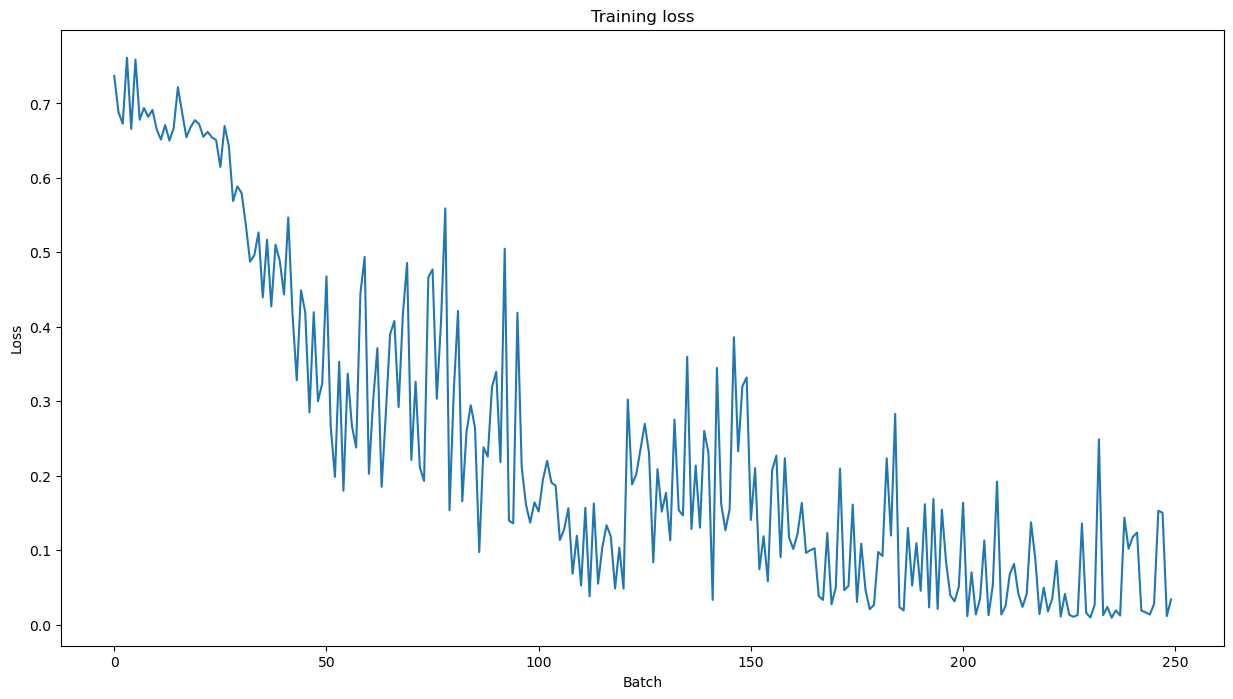

In [13]:
import matplotlib.pyplot as plt
import numpy as np

#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()



14. evaluation separate sentence

In [17]:
# Example input sentence
new_input = "The movie was absolutely fantastic!"
#new_input = "The movie was absolutely awful!"

In [18]:



# Tokenize and encode the input sentence
inputs = tokenizer.encode_plus(
    new_input,
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Move the inputs to the device
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

# Put the model in evaluation mode
model.eval()

# Predict sentiment
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits

# Extract the predicted class
predicted_class = np.argmax(logits.cpu().numpy(), axis=1)

# Map the predicted class to sentiment
class_mapping = {0: "negative", 1: "positive"}
predicted_sentiment = class_mapping[predicted_class[0]]

print(f"Predicted Sentiment: {predicted_sentiment}")


Predicted Sentiment: positive


15. evaluation held out test set

In [19]:
# Load a hold-out test dataset from rows 2000 to 3000 of the IMDB dataset
start_row = 2000
end_row = 3000
nrows = end_row - start_row + 1

# Use skiprows to skip rows up to the start_row and nrows to specify the number of rows to read
df_test = pd.read_csv("IMDB Dataset.csv", skiprows=range(1, start_row), nrows=nrows)

# Clean the test dataset
df_test['review'] = df_test['review'].apply(clean_text)

# Map the sentiment to numeric values (0: negative, 1: positive)
df_test['sentiment_numeric'] = df_test['sentiment'].map(label_map)



In [20]:
df_test.head()

,review,sentiment,sentiment_numeric
0,This was the worst movie I have ever seen Bill...,negative,0
1,Stranded in Space (1972) MST3K version - a ver...,negative,0
2,- After their sons are sentenced to life in pr...,positive,1
3,I love playing football and I thought this mov...,positive,1
4,This Showtime cable film features a talented c...,positive,1


In [21]:
# Tokenize the test set
test_inputs = tokenizer(
    df_test['review'].values.tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

test_input_ids = test_inputs['input_ids']
test_attention_masks = test_inputs['attention_mask']
test_labels = torch.tensor(df_test['sentiment_numeric'].values)

# Create a TensorDataset for the test set
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create DataLoader for the test set
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Evaluate the model on the test set
model.eval()

test_preds = []
test_labels_list = []

for batch in test_dataloader:
    b_input_ids, b_attention_mask, b_labels = batch
    b_input_ids = b_input_ids.to(device)
    b_attention_mask = b_attention_mask.to(device)
    b_labels = b_labels.to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()

    preds_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()

    test_preds.extend(preds_flat)
    test_labels_list.extend(labels_flat)




In [22]:
# Calculate accuracy and F1-score on the test set
test_accuracy = accuracy_score(test_labels_list, test_preds)
test_f1 = f1_score(test_labels_list, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.9021
Test F1 Score: 0.9043


In [23]:
from sklearn.metrics import classification_report

# Assuming binary classification where class 0 = Negative and class 1 = Positive
class_labels = ["Negative", "Positive"]

# Generate the classification report
report = classification_report(test_labels_list, test_preds, target_names=class_labels)

# Print the classification report
print("\nClassification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.88      0.90       498
    Positive       0.89      0.92      0.90       503

    accuracy                           0.90      1001
   macro avg       0.90      0.90      0.90      1001
weighted avg       0.90      0.90      0.90      1001



16. confusion matrix evaluation held out test set

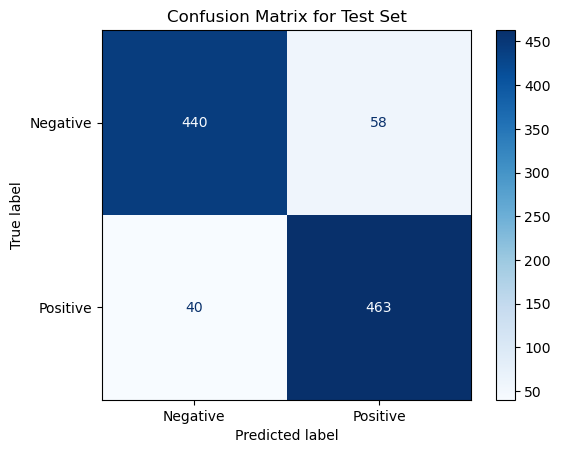

In [24]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(test_labels_list, test_preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()